Plotting transformed images for class: Powdery mildew
Plotting transformed images for class: Healthy
Plotting transformed images for class: Cotton Boll Rot
Plotting transformed images for class: Bacterial blight
Plotting transformed images for class: Aphids


C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/125 - Loss: 1.1720 Acc: 0.6198
Epoch 2/125 - Loss: 0.7302 Acc: 0.7761
Epoch 3/125 - Loss: 0.6379 Acc: 0.7981
Epoch 4/125 - Loss: 0.5632 Acc: 0.8245
Epoch 5/125 - Loss: 0.5162 Acc: 0.8357
Epoch 6/125 - Loss: 0.5041 Acc: 0.8405
Epoch 7/125 - Loss: 0.4717 Acc: 0.8500
Epoch 8/125 - Loss: 0.4570 Acc: 0.8523
Epoch 9/125 - Loss: 0.4342 Acc: 0.8558
Epoch 10/125 - Loss: 0.4094 Acc: 0.8727
Epoch 11/125 - Loss: 0.4041 Acc: 0.8746
Epoch 12/125 - Loss: 0.3949 Acc: 0.8705
Epoch 13/125 - Loss: 0.3764 Acc: 0.8841
Epoch 14/125 - Loss: 0.3638 Acc: 0.8804
Epoch 15/125 - Loss: 0.3721 Acc: 0.8754
Epoch 16/125 - Loss: 0.3591 Acc: 0.8820
Epoch 17/125 - Loss: 0.3564 Acc: 0.8850
Epoch 18/125 - Loss: 0.3413 Acc: 0.8858
Epoch 19/125 - Loss: 0.3257 Acc: 0.8948
Epoch 20/125 - Loss: 0.3323 Acc: 0.8896
Epoch 21/125 - Loss: 0.3179 Acc: 0.9010
Epoch 22/125 - Loss: 0.3155 Acc: 0.8983
Epoch 23/125 - Loss: 0.3120 Acc: 0.9004
Epoch 24/125 - Loss: 0.3238 Acc: 0.8912
Epoch 25/125 - Loss: 0.3084 Acc: 0.9046
Epoch 26/

C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The image is classified as class: Bacterial blight
Execution time: 26644.00754570961 seconds


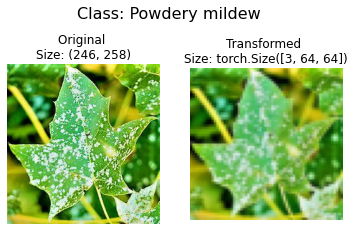

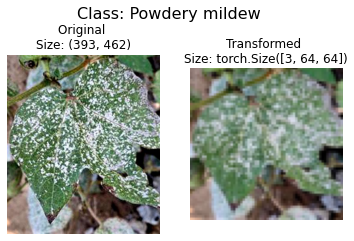

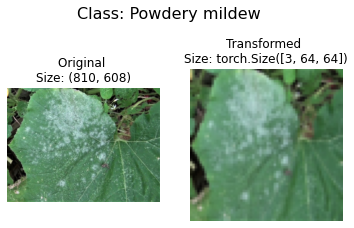

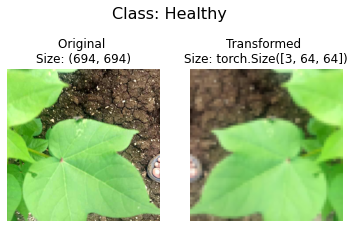

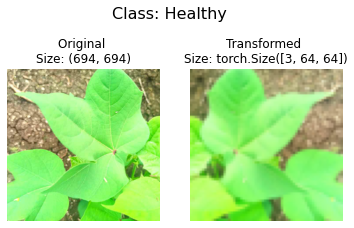

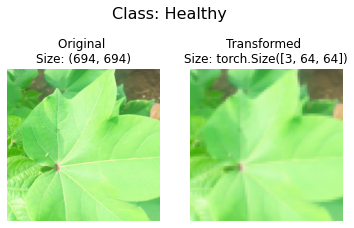

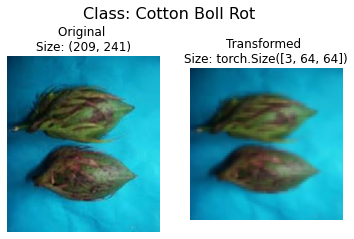

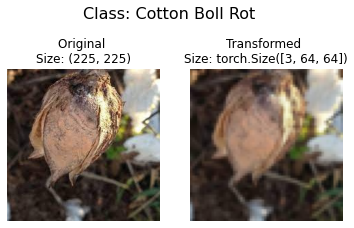

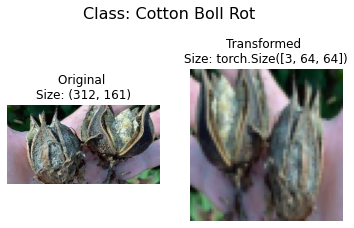

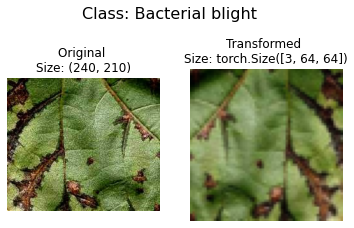

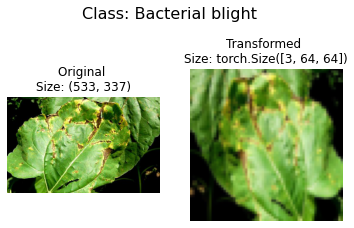

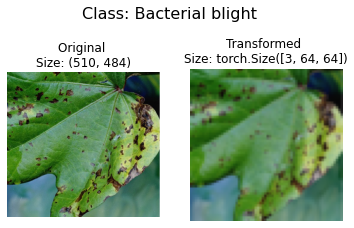

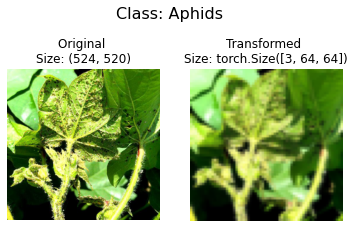

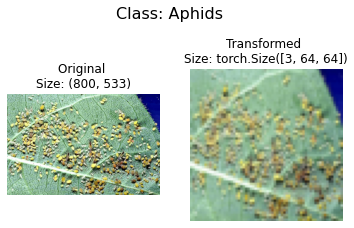

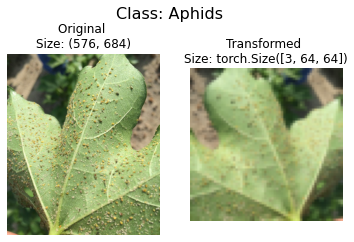

In [1]:
import time
start_time = time.time()
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            class_name = os.path.basename(os.path.dirname(image_path))
            fig.suptitle(f"Class: {class_name}", fontsize=16)

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

main_folder = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images"

classes = ["Powdery mildew", "Healthy", "Cotton Boll Rot", "Bacterial blight", "Aphids"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

class_images = {cls: [] for cls in classes}

for cls in classes:
    class_folder = os.path.join(main_folder, cls)
    for filename in os.listdir(class_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_folder, filename)
            class_images[cls].append(img_path)

image_path_list = {cls: images for cls, images in class_images.items()}

for cls in classes:
    print(f"Plotting transformed images for class: {cls}")
    plot_transformed_images(image_path_list[cls], transform=data_transform, n=3)

train_data = datasets.ImageFolder(root=main_folder, transform=data_transform)
class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

# Use ResNeXt-50 architecture
model = models.resnext50_32x4d(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 125
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = corrects.double() / len(train_data)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the fine-tuned model
torch.save(model.state_dict(), "first_tuned_model_resnext_cotton_disease.pth")

# Testing phase
test_image_path = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\cotton_segment.jpg"
test_image = Image.open(test_image_path)

data_transform_test = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

transformed_test_image = data_transform_test(test_image)
transformed_test_image = transformed_test_image.unsqueeze(0)

# Create a new model for testing
model_test = models.resnext50_32x4d(pretrained=False)
num_ftrs_test = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs_test, len(class_names))  # Ensure the number of classes matches the original configuration
model_test.load_state_dict(torch.load("first_tuned_model_resnext_cotton_disease.pth"))
model_test.eval()
transformed_test_image = transformed_test_image.to(device)
model_test = model_test.to(device)

with torch.no_grad():
    outputs_test = model_test(transformed_test_image)
    _, predicted_test = torch.max(outputs_test, 1)

predicted_class_test = class_names[predicted_test.item()]
print(f"The image is classified as class: {predicted_class_test}")

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Execution time: {elapsed_time} seconds")